In [1]:
import sys
sys.path.insert(1, '../..')

import torch
import torch.nn as nn
import random
import pandas as pd
import numpy as np
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

torch.manual_seed(33)
np.random.seed(33)
random.seed(33)

from library.evaluation import ConfusionMatrix

dataset_name = "Phemernr2-TF"
unique_name = "RoBERTa_Finetuned"

c:\Users\msi_b\anaconda3\envs\pytorch-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
vectors = np.loadtxt("../../data/vectors/Phemernr2-TF_RoBERTa_base_finetuned_vectors.txt", delimiter=",")
vectors.shape

(1705, 768)

In [3]:
data = pd.read_csv("../../data/processed/phemernr2-tf_dataset.csv", sep=",")
data.head()

,tweet_id,tweet_text,label,topic,tvt2
0,580318210609696769,BREAKING - A Germanwings Airbus A320 plane rep...,True,germanwings-crash-all-rnr-threads,training
1,552798891994009601,Reports that two of the dead in the #CharlieHe...,True,charliehebdo-all-rnr-threads,training
2,580352540316946432,'No survivors' in #Germanwings crash says Fren...,False,germanwings-crash-all-rnr-threads,training
3,524983403775799297,Tragedy mounts as soldier shot this AM dies of...,True,ottawashooting-all-rnr-threads,training
4,544511915158810624,Watch the moment gunfire and explosions were h...,True,sydneysiege-all-rnr-threads,training


In [4]:
labels_str = data['label'].unique().tolist()
labels_str

[True, False]

In [5]:
labels = []
for i, d in data.iterrows():
    lab = labels_str.index(d['label'])
#     labels.append([1 if j == lab else 0 for j in range(len(labels_str))])
    labels.append(lab)
labels[:10]

[0, 0, 1, 0, 0, 0, 0, 1, 0, 0]

In [6]:
train_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'training'])
val_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'validation'])
test_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'testting'])

train_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'training'])
val_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'validation'])
test_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'testting'])

In [7]:
print(train_vectors.shape)
print(val_vectors.shape)
print(test_vectors.shape)

print(train_labels.shape)
print(val_labels.shape)
print(test_labels.shape)

(1176, 768)
(371, 768)
(158, 768)
(1176,)
(371,)
(158,)


In [8]:
for_cv_vectors = np.concatenate((train_vectors, val_vectors))
train_vectors = None
val_vectors = None
print(for_cv_vectors.shape)

(1547, 768)


In [9]:
for_cv_labels = np.concatenate((train_labels, val_labels))
train_labels = None
val_labels = None
print(for_cv_labels.shape)

(1547,)


In [10]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import os
from typing import Callable


class NNModel(nn.Module):
    def __init__(
        self,
        n_input: int,
        n_output: int = 1
    ):
        super(NNModel, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(n_input, 512),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(512),
            nn.Dropout(p=0.5),
            nn.Linear(512, 512),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(512),
            nn.Dropout(p=0.5),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(256),
            nn.Dropout(p=0.5),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.1),
#             nn.BatchNorm1d(128),
            nn.Dropout(p=0.5),
            nn.Linear(128, n_output)
        )

    def forward(self, input):
        return self.main(input)
    

class NNClassifier:
    def __init__(self,
        n_input: int,
        n_output: int = 1,
        criterion: Callable = nn.BCELoss,
        beta1: float = 0.5,
        lr: float = 0.0002,
        device: str = None
    ):
        super(NNClassifier, self).__init__()
        self.model = NNModel(n_input, n_output)

        self.criterion = criterion()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)

        if not device or device not in ['cpu', 'cuda']:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        else:
            self.device = device

        self.model = self.model.to(self.device)
        if self.device == 'cuda':
            self.model = torch.nn.DataParallel(self.model)
            cudnn.benchmark = True
    
    def load_pretrained(self, filepath: str, key: str = "net", is_parallel: bool = False):
        checkpoint = torch.load(filepath)
        if is_parallel:
            self.model = torch.nn.DataParallel(self.model)
            cudnn.benchmark = True

        print(f"loading model from {filepath}...")
#         print(checkpoint[key])
        self.model.load_state_dict(checkpoint[key], strict=False)
    
    def save_model(self, saves: str):
        print(f"Saving model...")
        state = {
            'net': self.model.state_dict()
        }
        if not os.path.isdir('models'):
            os.mkdir('models')
        torch.save(state, f"../../data/models/cross-validation/{saves}.pth")
    
    def train_eval(self,
        train_x, train_y,
        test_x, test_y,
        n_iter: int = 100,
        batch_size: int = 128,
        saves: str = None,
        fold: int = None
    ):
        trainset = torch.utils.data.TensorDataset(train_x, train_y) # create your datset
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size) # create your dataloader

        testset = torch.utils.data.TensorDataset(test_x, test_y) # create your datset
        testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size) # create your dataloader

        train_accs = []
        train_losses = []
        test_accs = []
        test_losses = []

        print(f"Using {self.device}")
        best_acc = 0
        current_loss = 1000
        best_test_acc = 0
        epoch = 0
        start_time = time.time()
        results = {}
        while True:
            epoch += 1
            self.model.train()
            train_loss = 0
            train_correct = 0
            train_total = 0
            for idx, (inputs, targets) in enumerate(trainloader):
                self.optimizer.zero_grad()
                inputs, targets=inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets.long())
                loss.backward()
                self.optimizer.step()

                _, predicted = outputs.max(1)
                train_loss += loss.item()
                train_total += targets.size(0)
                train_correct += predicted.eq(targets).sum().item()
            
            train_acc=100.*train_correct/train_total
            train_accs.append(train_acc)
            train_losses.append(train_loss/len(trainloader))
            

            self.model.eval()
            test_loss = 0
            test_correct = 0
            test_total = 0
            # test_acc = 0
            with torch.no_grad():
                for idx, (inputs, targets) in enumerate(testloader):
                    inputs, targets = inputs.to(self.device), targets.to(self.device)
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, targets.long())
                    test_loss += loss.item()
            
                    _, predicted = outputs.max(1)
                    test_total += targets.size(0)
                    test_correct += predicted.eq(targets).sum().item()
                
            test_acc=100.*test_correct/test_total
            test_accs.append(test_acc)
            test_losses.append(test_loss/len(testloader))
            
            if (epoch) % round(n_iter/20) == 0:
                print(f"-- Epoch {epoch}, Train_Accuracy : {train_acc}, Validation Accuracy : {test_acc}, Train Loss : {train_loss}, Validation Loss : {test_loss}")

            # Save checkpoint.
            # if saves and test_loss < best_loss:
            #     print(f"Saving after new best loss : {test_loss}")
            #     best_loss = test_loss
            if saves and test_acc > best_test_acc:
                print(f"Saving after new best accuracy : {test_acc}")
                best_test_acc = test_acc

                state = {
                    'net': self.model.state_dict(),
                }
                if not os.path.isdir('models'):
                    os.mkdir('models')
                torch.save(state, f"../../data/models/cross-validation/{saves}.pth")
            
            if epoch >= n_iter:
                break
            
        # visualizing accuracy over epoch
        fig, ax2 = plt.subplots(1)
        plt.subplots_adjust(hspace=1.5, wspace=0.4)
        ax2.plot([i for i in range(len(train_accs))], train_accs, label='Training Accuracy')
        ax2.plot([i for i in range(len(test_accs))], test_accs, label='Validation Accuracy')
        ax2.set_ylabel('Accuracy')
        ax2.set_xlabel('Epoch')
        # ax2.set_xlim(0, len(train_losses))
        # ax2.set_ylim(min([min(train_losses), min(test_losses)])*0.1, max([max(train_losses), max(test_losses)]))
        ax2.title.set_text(f"Training and Validation Accuracy Over Time (epoch) Fold {fold}")
        ax2.legend(loc='lower right')

        plt.show()
        fig.savefig(f"../../Grafik/Accuracy/Cross-Validation/{dataset_name}_4LayerNet_L2Reg_{unique_name}_Accuracy_Graph_Fold{fold}.png")
        
        # visualizing accuracy over epoch
        fig, ax2 = plt.subplots(1)
        plt.subplots_adjust(hspace=1.5, wspace=0.4)
        ax2.plot([i for i in range(len(train_losses))], train_losses, label='Training Loss')
        ax2.plot([i for i in range(len(test_losses))], test_losses, label='Validation Loss')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        # ax2.set_xlim(0, len(train_losses))
        # ax2.set_ylim(min([min(train_losses), min(test_losses)])*0.1, max([max(train_losses), max(test_losses)]))
        ax2.title.set_text(f"Training and Validation Loss Over Time (epoch) Fold {fold}")
        ax2.legend(loc='lower right')

        plt.show()
        fig.savefig(f"../../Grafik/Loss/Cross-Validation/{dataset_name}_4LayerNet_L2Reg_{unique_name}_Loss_Graph_Fold{fold}.png")
    
    def predict(self, input_x):
        self.model.eval()
        with torch.no_grad():
            preds = self.model(torch.Tensor(input_x))
            preds = torch.log_softmax(preds, dim = 1)
            _, preds = torch.max(preds, dim = 1)
            return preds

In [11]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=5)

Multiclass Classification using 4-Layer Linear Network Cross Validation
--- FOLD 1 ----
Using cuda
Saving after new best accuracy : 92.25806451612904
Saving after new best accuracy : 98.38709677419355
Saving after new best accuracy : 98.70967741935483
-- Epoch 50, Train_Accuracy : 98.3023443815683, Validation Accuracy : 97.09677419354838, Train Loss : 0.194805720821023, Validation Loss : 0.055793240666389465
Saving after new best accuracy : 99.03225806451613
Saving after new best accuracy : 99.35483870967742
-- Epoch 100, Train_Accuracy : 99.4341147938561, Validation Accuracy : 98.38709677419355, Train Loss : 0.05769994622096419, Validation Loss : 0.040351174771785736
-- Epoch 150, Train_Accuracy : 99.83831851253032, Validation Accuracy : 98.38709677419355, Train Loss : 0.028117447160184383, Validation Loss : 0.07516175508499146
-- Epoch 200, Train_Accuracy : 99.67663702506063, Validation Accuracy : 99.03225806451613, Train Loss : 0.03872051159851253, Validation Loss : 0.04563609138131

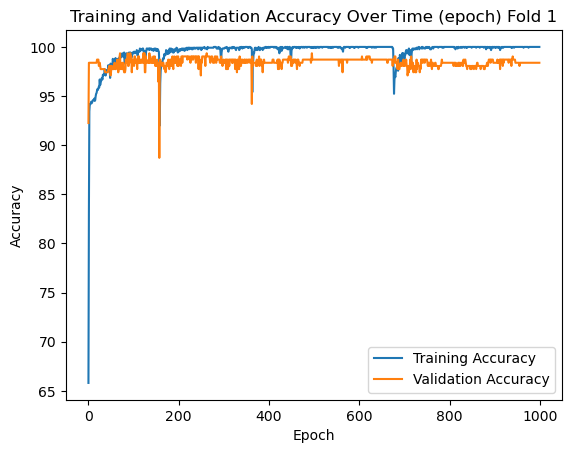

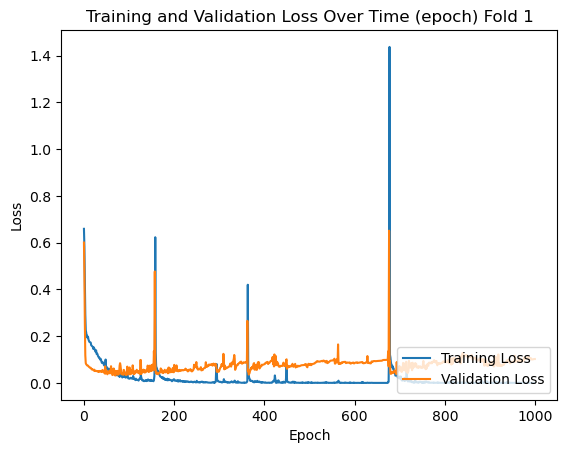

Exec Time : 25.39 seconds
loading model from ../../data/models/cross-validation/Phemernr2-TF_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold1.pth...

Train Set
Predictions : torch.Size([1237])
Binary Class Evaluation

True Positive : 450
False Positive : 1
False Negative : 11
True Negative : 775

Class False Evaluation
- Precision : 99.778 %
- Recall : 97.614 %
- F1 : 0.98684

Class True Evaluation
- Precision : 98.601 %
- Recall : 99.871 %
- F1 : 0.99232

Combined Evaluation
- Accuracy : 99.03 %
- Precision : 99.189 %
- Recall : 98.743 %
- F1 : 0.98965
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Phemernr2-TF_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold1 Train, 99.03, 99.189, 98.743, 0.98965, 99.778, 97.614, 0.98684, 98.601, 99.871, 0.99232, 
Confusion Matrix Scikit-learn: 
[[775   1]
 [ 11 450]]


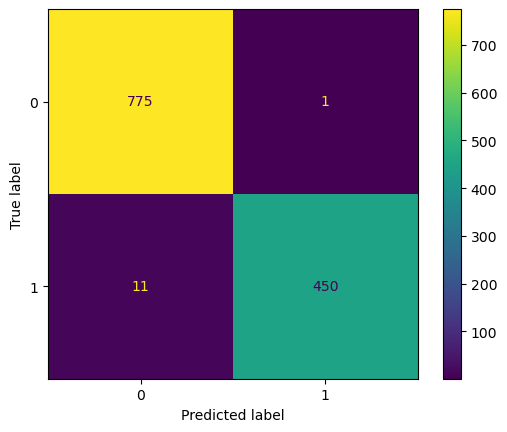


Validation Set
Predictions : torch.Size([310])
Binary Class Evaluation

True Positive : 114
False Positive : 0
False Negative : 2
True Negative : 194

Class False Evaluation
- Precision : 100.0 %
- Recall : 98.276 %
- F1 : 0.9913

Class True Evaluation
- Precision : 98.98 %
- Recall : 100.0 %
- F1 : 0.99487

Combined Evaluation
- Accuracy : 99.355 %
- Precision : 99.49 %
- Recall : 99.138 %
- F1 : 0.99314
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Phemernr2-TF_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold1 Validation, 99.355, 99.49, 99.138, 0.99314, 100.0, 98.276, 0.9913, 98.98, 100.0, 0.99487, 
Confusion Matrix Scikit-learn: 
[[194   0]
 [  2 114]]


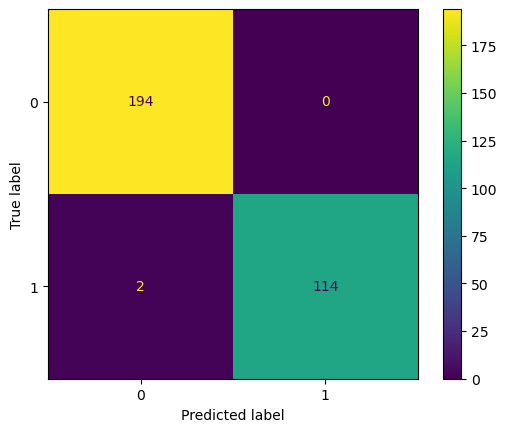


Test Set
Predictions : torch.Size([158])
Binary Class Evaluation

True Positive : 50
False Positive : 7
False Negative : 11
True Negative : 90

Class False Evaluation
- Precision : 87.719 %
- Recall : 81.967 %
- F1 : 0.84746

Class True Evaluation
- Precision : 89.109 %
- Recall : 92.784 %
- F1 : 0.90909

Combined Evaluation
- Accuracy : 88.608 %
- Precision : 88.414 %
- Recall : 87.375 %
- F1 : 0.87891
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Phemernr2-TF_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold1 Test, 88.608, 88.414, 87.375, 0.87891, 87.719, 81.967, 0.84746, 89.109, 92.784, 0.90909, 
158
158
Confusion Matrix Scikit-learn: 
[[90  7]
 [11 50]]


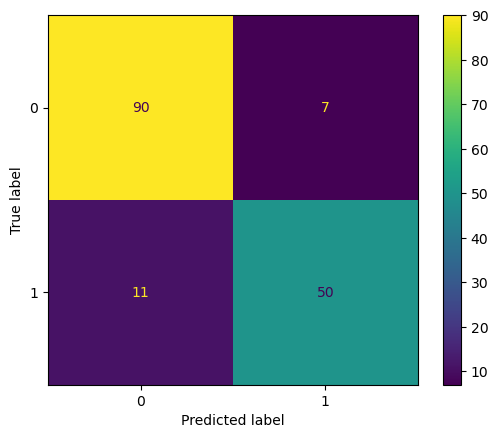

--- FOLD 2 ----
Using cuda
Saving after new best accuracy : 74.83870967741936
Saving after new best accuracy : 96.45161290322581
Saving after new best accuracy : 97.41935483870968
Saving after new best accuracy : 97.74193548387096
Saving after new best accuracy : 98.06451612903226
Saving after new best accuracy : 98.38709677419355
Saving after new best accuracy : 98.70967741935483
-- Epoch 50, Train_Accuracy : 98.05982215036379, Validation Accuracy : 97.74193548387096, Train Loss : 0.2296910099685192, Validation Loss : 0.0600406788289547
-- Epoch 100, Train_Accuracy : 99.51495553759095, Validation Accuracy : 99.03225806451613, Train Loss : 0.06351110059767962, Validation Loss : 0.08139234781265259
Saving after new best accuracy : 99.03225806451613
Saving after new best accuracy : 99.35483870967742
-- Epoch 150, Train_Accuracy : 99.75747776879547, Validation Accuracy : 98.70967741935483, Train Loss : 0.055310580879449844, Validation Loss : 0.09527688473463058
-- Epoch 200, Train_Accurac

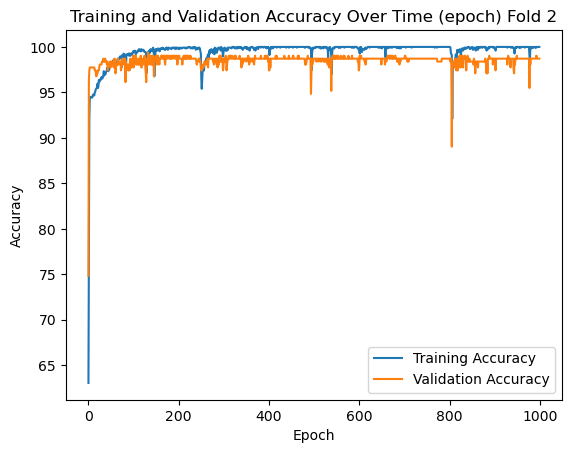

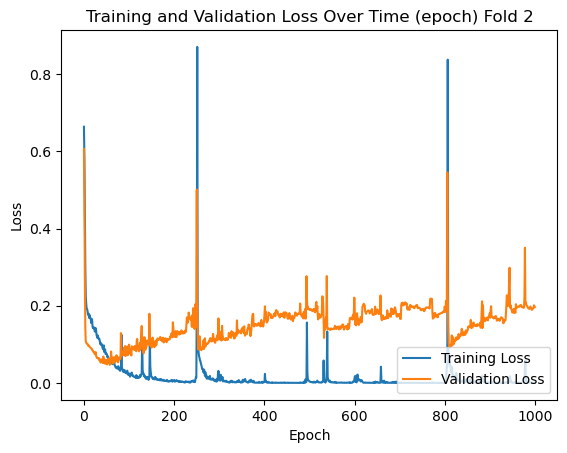

Exec Time : 22.94 seconds
loading model from ../../data/models/cross-validation/Phemernr2-TF_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold2.pth...

Train Set
Predictions : torch.Size([1237])
Binary Class Evaluation

True Positive : 459
False Positive : 0
False Negative : 2
True Negative : 776

Class False Evaluation
- Precision : 100.0 %
- Recall : 99.566 %
- F1 : 0.99783

Class True Evaluation
- Precision : 99.743 %
- Recall : 100.0 %
- F1 : 0.99871

Combined Evaluation
- Accuracy : 99.838 %
- Precision : 99.871 %
- Recall : 99.783 %
- F1 : 0.99827
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Phemernr2-TF_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold2 Train, 99.838, 99.871, 99.783, 0.99827, 100.0, 99.566, 0.99783, 99.743, 100.0, 0.99871, 
Confusion Matrix Scikit-learn: 
[[776   0]
 [  2 459]]


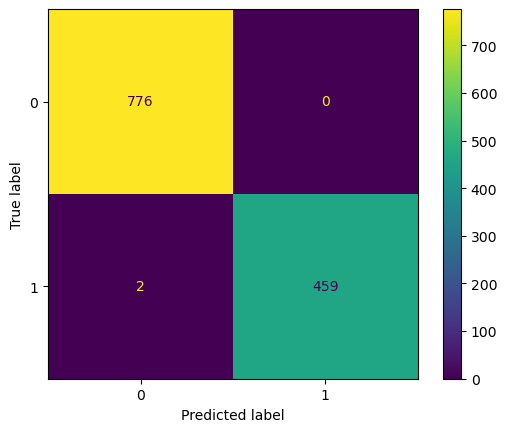


Validation Set
Predictions : torch.Size([310])
Binary Class Evaluation

True Positive : 115
False Positive : 1
False Negative : 1
True Negative : 193

Class False Evaluation
- Precision : 99.138 %
- Recall : 99.138 %
- F1 : 0.99138

Class True Evaluation
- Precision : 99.485 %
- Recall : 99.485 %
- F1 : 0.99485

Combined Evaluation
- Accuracy : 99.355 %
- Precision : 99.311 %
- Recall : 99.311 %
- F1 : 0.99311
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Phemernr2-TF_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold2 Validation, 99.355, 99.311, 99.311, 0.99311, 99.138, 99.138, 0.99138, 99.485, 99.485, 0.99485, 
Confusion Matrix Scikit-learn: 
[[193   1]
 [  1 115]]


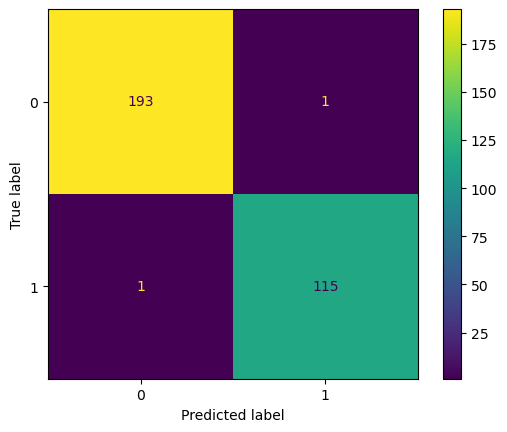


Test Set
Predictions : torch.Size([158])
Binary Class Evaluation

True Positive : 50
False Positive : 6
False Negative : 11
True Negative : 91

Class False Evaluation
- Precision : 89.286 %
- Recall : 81.967 %
- F1 : 0.8547

Class True Evaluation
- Precision : 89.216 %
- Recall : 93.814 %
- F1 : 0.91457

Combined Evaluation
- Accuracy : 89.241 %
- Precision : 89.251 %
- Recall : 87.891 %
- F1 : 0.88566
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Phemernr2-TF_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold2 Test, 89.241, 89.251, 87.891, 0.88566, 89.286, 81.967, 0.8547, 89.216, 93.814, 0.91457, 
158
158
Confusion Matrix Scikit-learn: 
[[91  6]
 [11 50]]


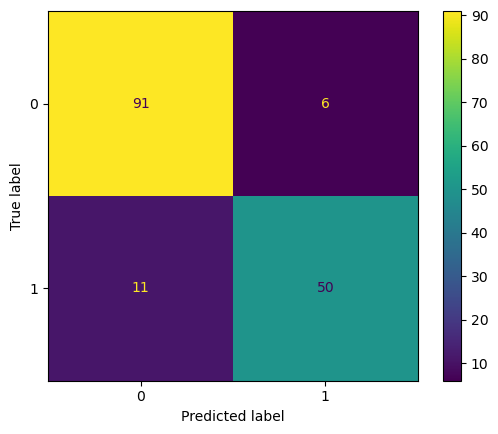

--- FOLD 3 ----
Using cuda
Saving after new best accuracy : 96.44012944983818
Saving after new best accuracy : 97.0873786407767
Saving after new best accuracy : 97.41100323624596
Saving after new best accuracy : 97.73462783171522
Saving after new best accuracy : 98.38187702265373
Saving after new best accuracy : 98.70550161812298
Saving after new best accuracy : 99.02912621359224
-- Epoch 50, Train_Accuracy : 97.89983844911147, Validation Accuracy : 97.73462783171522, Train Loss : 0.20430454425513744, Validation Loss : 0.054338861256837845
-- Epoch 100, Train_Accuracy : 99.19224555735056, Validation Accuracy : 98.38187702265373, Train Loss : 0.09190856292843819, Validation Loss : 0.06317887455224991
-- Epoch 150, Train_Accuracy : 99.83844911147011, Validation Accuracy : 98.38187702265373, Train Loss : 0.027438461780548096, Validation Loss : 0.058841366320848465
-- Epoch 200, Train_Accuracy : 99.59612277867528, Validation Accuracy : 98.05825242718447, Train Loss : 0.028978419490158558, 

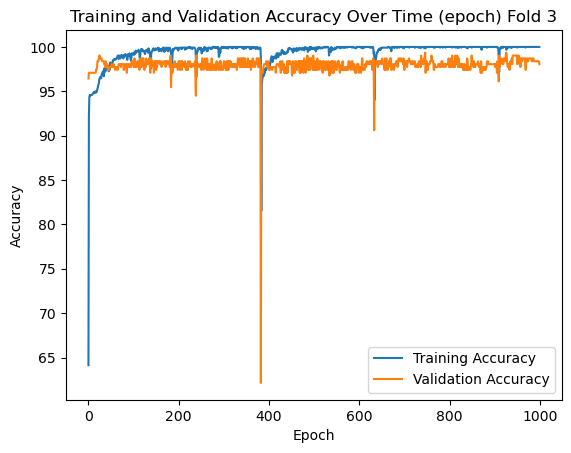

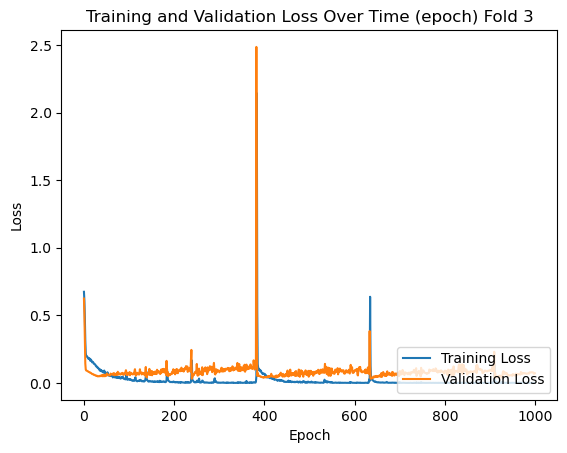

Exec Time : 21.16 seconds
loading model from ../../data/models/cross-validation/Phemernr2-TF_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold3.pth...

Train Set
Predictions : torch.Size([1238])
Binary Class Evaluation

True Positive : 462
False Positive : 0
False Negative : 0
True Negative : 776

Class False Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Class True Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Combined Evaluation
- Accuracy : 100.0 %
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Phemernr2-TF_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold3 Train, 100.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 
Confusion Matrix Scikit-learn: 
[[776   0]
 [  0 462]]


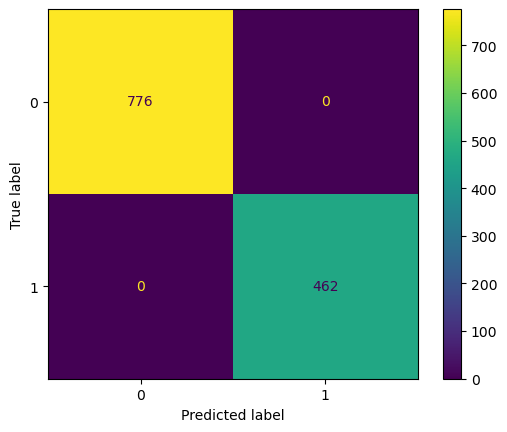


Validation Set
Predictions : torch.Size([309])
Binary Class Evaluation

True Positive : 113
False Positive : 0
False Negative : 2
True Negative : 194

Class False Evaluation
- Precision : 100.0 %
- Recall : 98.261 %
- F1 : 0.99123

Class True Evaluation
- Precision : 98.98 %
- Recall : 100.0 %
- F1 : 0.99487

Combined Evaluation
- Accuracy : 99.353 %
- Precision : 99.49 %
- Recall : 99.13 %
- F1 : 0.9931
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Phemernr2-TF_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold3 Validation, 99.353, 99.49, 99.13, 0.9931, 100.0, 98.261, 0.99123, 98.98, 100.0, 0.99487, 
Confusion Matrix Scikit-learn: 
[[194   0]
 [  2 113]]


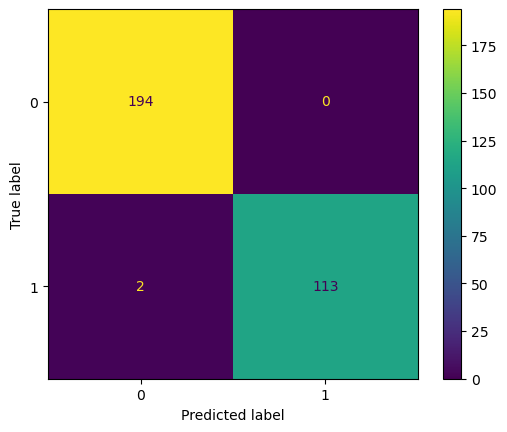


Test Set
Predictions : torch.Size([158])
Binary Class Evaluation

True Positive : 53
False Positive : 8
False Negative : 8
True Negative : 89

Class False Evaluation
- Precision : 86.885 %
- Recall : 86.885 %
- F1 : 0.86885

Class True Evaluation
- Precision : 91.753 %
- Recall : 91.753 %
- F1 : 0.91753

Combined Evaluation
- Accuracy : 89.873 %
- Precision : 89.319 %
- Recall : 89.319 %
- F1 : 0.89319
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Phemernr2-TF_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold3 Test, 89.873, 89.319, 89.319, 0.89319, 86.885, 86.885, 0.86885, 91.753, 91.753, 0.91753, 
158
158
Confusion Matrix Scikit-learn: 
[[89  8]
 [ 8 53]]


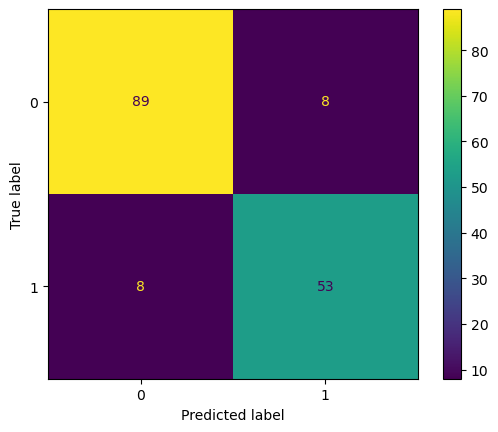

--- FOLD 4 ----
Using cuda
Saving after new best accuracy : 95.14563106796116
Saving after new best accuracy : 95.46925566343042
Saving after new best accuracy : 96.11650485436893
Saving after new best accuracy : 96.44012944983818
Saving after new best accuracy : 96.76375404530744
Saving after new best accuracy : 97.0873786407767
Saving after new best accuracy : 97.41100323624596
Saving after new best accuracy : 97.73462783171522
-- Epoch 50, Train_Accuracy : 98.46526655896608, Validation Accuracy : 97.73462783171522, Train Loss : 0.16379048116505146, Validation Loss : 0.09254540503025055
Saving after new best accuracy : 98.05825242718447
-- Epoch 100, Train_Accuracy : 98.94991922455573, Validation Accuracy : 92.88025889967638, Train Loss : 0.1199232880026102, Validation Loss : 0.28959324955940247
-- Epoch 150, Train_Accuracy : 99.75767366720517, Validation Accuracy : 96.76375404530744, Train Loss : 0.02207382838241756, Validation Loss : 0.21658998727798462
-- Epoch 200, Train_Accuracy

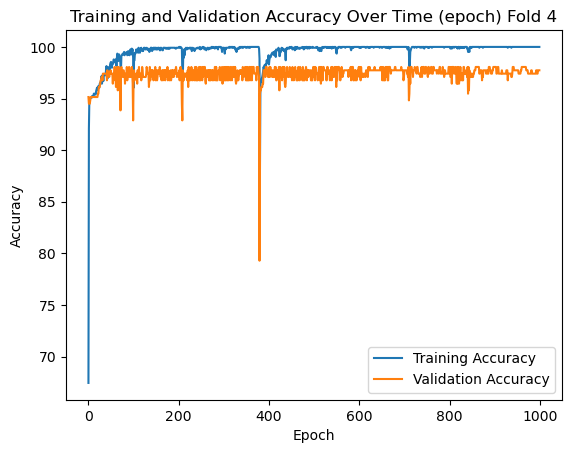

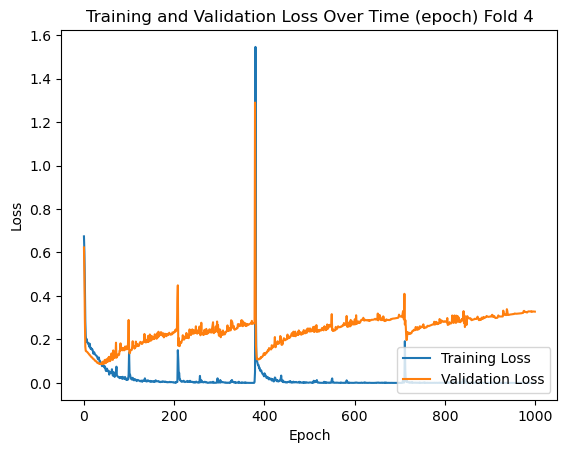

Exec Time : 21.75 seconds
loading model from ../../data/models/cross-validation/Phemernr2-TF_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold4.pth...

Train Set
Predictions : torch.Size([1238])
Binary Class Evaluation

True Positive : 449
False Positive : 0
False Negative : 13
True Negative : 776

Class False Evaluation
- Precision : 100.0 %
- Recall : 97.186 %
- F1 : 0.98573

Class True Evaluation
- Precision : 98.352 %
- Recall : 100.0 %
- F1 : 0.99169

Combined Evaluation
- Accuracy : 98.95 %
- Precision : 99.176 %
- Recall : 98.593 %
- F1 : 0.98884
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Phemernr2-TF_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold4 Train, 98.95, 99.176, 98.593, 0.98884, 100.0, 97.186, 0.98573, 98.352, 100.0, 0.99169, 
Confusion Matrix Scikit-learn: 
[[776   0]
 [ 13 449]]


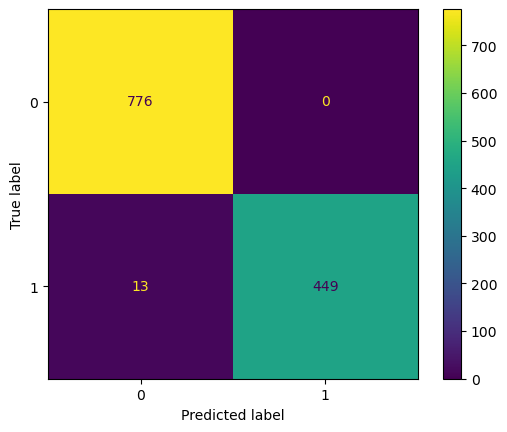


Validation Set
Predictions : torch.Size([309])
Binary Class Evaluation

True Positive : 112
False Positive : 3
False Negative : 3
True Negative : 191

Class False Evaluation
- Precision : 97.391 %
- Recall : 97.391 %
- F1 : 0.97391

Class True Evaluation
- Precision : 98.454 %
- Recall : 98.454 %
- F1 : 0.98454

Combined Evaluation
- Accuracy : 98.058 %
- Precision : 97.922 %
- Recall : 97.922 %
- F1 : 0.97922
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Phemernr2-TF_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold4 Validation, 98.058, 97.922, 97.922, 0.97922, 97.391, 97.391, 0.97391, 98.454, 98.454, 0.98454, 
Confusion Matrix Scikit-learn: 
[[191   3]
 [  3 112]]


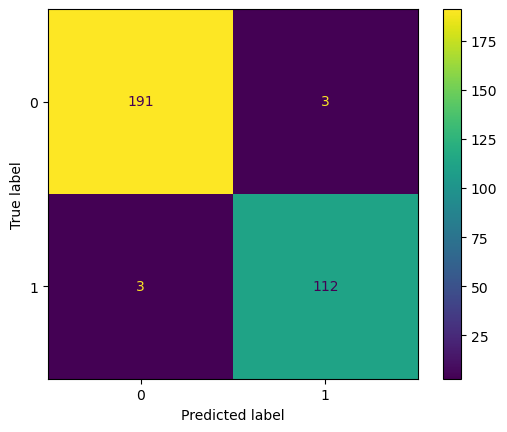


Test Set
Predictions : torch.Size([158])
Binary Class Evaluation

True Positive : 51
False Positive : 6
False Negative : 10
True Negative : 91

Class False Evaluation
- Precision : 89.474 %
- Recall : 83.607 %
- F1 : 0.86441

Class True Evaluation
- Precision : 90.099 %
- Recall : 93.814 %
- F1 : 0.91919

Combined Evaluation
- Accuracy : 89.873 %
- Precision : 89.786 %
- Recall : 88.71 %
- F1 : 0.89245
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Phemernr2-TF_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold4 Test, 89.873, 89.786, 88.71, 0.89245, 89.474, 83.607, 0.86441, 90.099, 93.814, 0.91919, 
158
158
Confusion Matrix Scikit-learn: 
[[91  6]
 [10 51]]


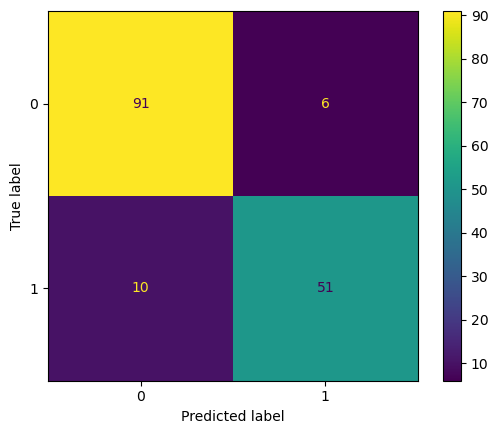

--- FOLD 5 ----
Using cuda
Saving after new best accuracy : 86.73139158576052
Saving after new best accuracy : 87.70226537216828
Saving after new best accuracy : 88.3495145631068
Saving after new best accuracy : 88.67313915857605
Saving after new best accuracy : 88.9967637540453
Saving after new best accuracy : 89.64401294498381
Saving after new best accuracy : 90.29126213592232
Saving after new best accuracy : 90.61488673139158
Saving after new best accuracy : 90.93851132686085
Saving after new best accuracy : 91.2621359223301
-- Epoch 50, Train_Accuracy : 99.11147011308562, Validation Accuracy : 91.2621359223301, Train Loss : 0.09882836975157261, Validation Loss : 0.3850608468055725
Saving after new best accuracy : 91.58576051779936
-- Epoch 100, Train_Accuracy : 100.0, Validation Accuracy : 90.61488673139158, Train Loss : 0.007232893607579172, Validation Loss : 0.6714807152748108
-- Epoch 150, Train_Accuracy : 100.0, Validation Accuracy : 90.61488673139158, Train Loss : 0.0016996201

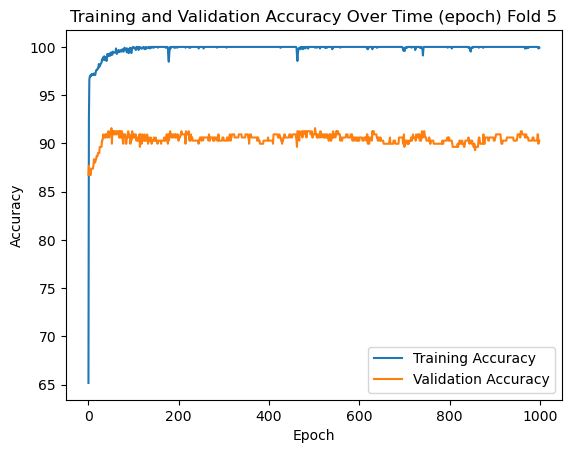

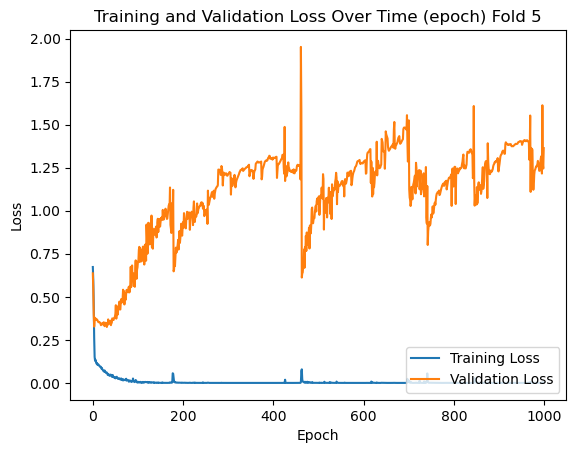

Exec Time : 22.57 seconds
loading model from ../../data/models/cross-validation/Phemernr2-TF_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold5.pth...

Train Set
Predictions : torch.Size([1238])
Binary Class Evaluation

True Positive : 453
False Positive : 0
False Negative : 9
True Negative : 776

Class False Evaluation
- Precision : 100.0 %
- Recall : 98.052 %
- F1 : 0.99016

Class True Evaluation
- Precision : 98.854 %
- Recall : 100.0 %
- F1 : 0.99423

Combined Evaluation
- Accuracy : 99.273 %
- Precision : 99.427 %
- Recall : 99.026 %
- F1 : 0.99226
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Phemernr2-TF_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold5 Train, 99.273, 99.427, 99.026, 0.99226, 100.0, 98.052, 0.99016, 98.854, 100.0, 0.99423, 
Confusion Matrix Scikit-learn: 
[[776   0]
 [  9 453]]


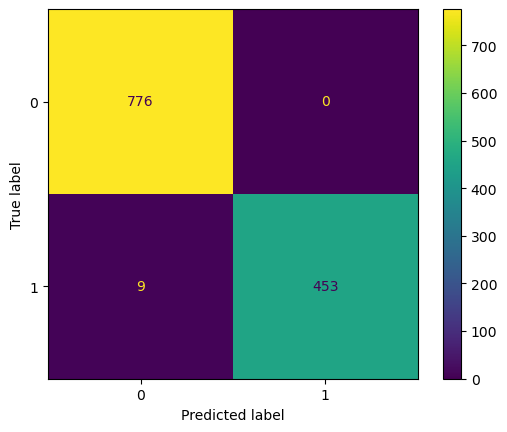


Validation Set
Predictions : torch.Size([309])
Binary Class Evaluation

True Positive : 96
False Positive : 7
False Negative : 19
True Negative : 187

Class False Evaluation
- Precision : 93.204 %
- Recall : 83.478 %
- F1 : 0.88073

Class True Evaluation
- Precision : 90.777 %
- Recall : 96.392 %
- F1 : 0.935

Combined Evaluation
- Accuracy : 91.586 %
- Precision : 91.99 %
- Recall : 89.935 %
- F1 : 0.90951
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Phemernr2-TF_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold5 Validation, 91.586, 91.99, 89.935, 0.90951, 93.204, 83.478, 0.88073, 90.777, 96.392, 0.935, 
Confusion Matrix Scikit-learn: 
[[187   7]
 [ 19  96]]


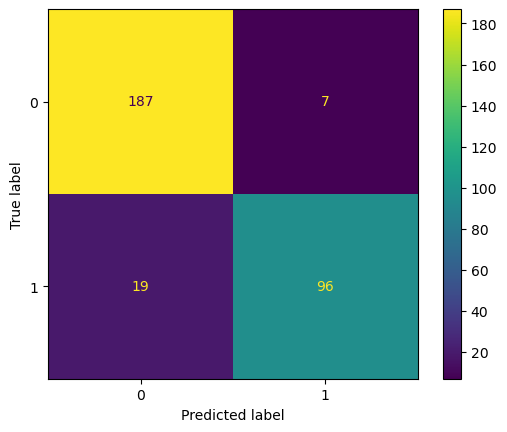


Test Set
Predictions : torch.Size([158])
Binary Class Evaluation

True Positive : 53
False Positive : 8
False Negative : 8
True Negative : 89

Class False Evaluation
- Precision : 86.885 %
- Recall : 86.885 %
- F1 : 0.86885

Class True Evaluation
- Precision : 91.753 %
- Recall : 91.753 %
- F1 : 0.91753

Combined Evaluation
- Accuracy : 89.873 %
- Precision : 89.319 %
- Recall : 89.319 %
- F1 : 0.89319
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Phemernr2-TF_4LayerNet_L2Reg_RoBERTa_Finetuned_Fold5 Test, 89.873, 89.319, 89.319, 0.89319, 86.885, 86.885, 0.86885, 91.753, 91.753, 0.91753, 
158
158
Confusion Matrix Scikit-learn: 
[[89  8]
 [ 8 53]]


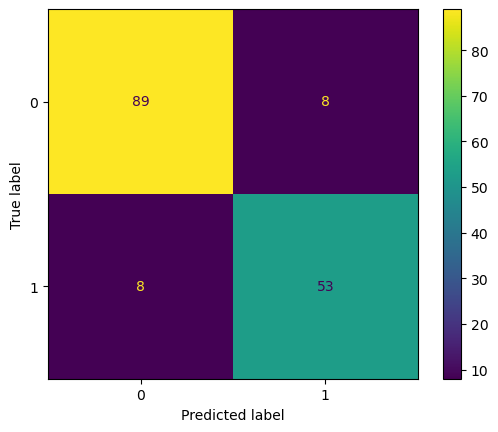

In [12]:
print("Multiclass Classification using 4-Layer Linear Network Cross Validation")

for i, (train_index, test_index) in enumerate(kf.split(for_cv_vectors, for_cv_labels)):
    print(f"--- FOLD {i+1} ----")
    train_vectors = for_cv_vectors[train_index]
    train_labels = for_cv_labels[train_index]
    val_vectors = for_cv_vectors[test_index]
    val_labels = for_cv_labels[test_index]
       
    start = time.time()
    model_name = f"{dataset_name}_4LayerNet_L2Reg_{unique_name}_Fold{i+1}"
    model = NNClassifier(train_vectors.shape[1], n_output=2, criterion=nn.CrossEntropyLoss)
    model.train_eval(torch.Tensor(train_vectors),
                    torch.Tensor(train_labels),
                    torch.Tensor(val_vectors),
                    torch.Tensor(val_labels),
                    saves=model_name,
                    n_iter=1000,
                    batch_size=512,
                    fold=i+1)
    print(f"Exec Time : {round(time.time() - start, 2)} seconds")

    model.load_pretrained(f"../../data/models/cross-validation/{model_name}.pth")

    print("\nTrain Set")
    preds = model.predict(train_vectors)
    print(f"Predictions : {preds.shape}")

    preds = preds.cpu().numpy()

    conf_mat = ConfusionMatrix(
        labels=np.array(train_labels),
        predictions=np.array(preds),
        binary=True,
        model_name=f"{model_name} Train"
    )
    conf_mat.evaluate(classes=labels_str)

    labels=np.array(train_labels)
    predictions=np.array(preds)
    cm = confusion_matrix(labels, predictions, labels=[0,1])
    print(f'Confusion Matrix Scikit-learn: \n{cm}')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.show()

    print("\nValidation Set")
    preds = model.predict(val_vectors)
    print(f"Predictions : {preds.shape}")

    preds = preds.cpu().numpy()

    conf_mat = ConfusionMatrix(
        labels=np.array(val_labels),
        predictions=np.array(preds),
        binary=True,
        model_name=f"{model_name} Validation"
    )
    conf_mat.evaluate(classes=labels_str)

    labels=np.array(val_labels)
    predictions=np.array(preds)
    cm = confusion_matrix(labels, predictions, labels=[0,1])
    print(f'Confusion Matrix Scikit-learn: \n{cm}')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.show()

    print("\nTest Set")
    preds = model.predict(test_vectors)
    print(f"Predictions : {preds.shape}")

    preds = preds.cpu().numpy()

    conf_mat = ConfusionMatrix(
        labels=np.array(test_labels),
        predictions=np.array(preds),
        binary=True,
        model_name=f"{model_name} Test"
    )
    conf_mat.evaluate(classes=labels_str)

    labels=np.array(test_labels)
    predictions=np.array(preds)
    print(len(labels))
    print(len(predictions))
    cm = confusion_matrix(labels, predictions, labels=[0,1])
    print(f'Confusion Matrix Scikit-learn: \n{cm}')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.show()